**Importing libraries**

In [1]:
# Keras e TF

#import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report, confusion_matrix

# Base
import os 
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns # 
import numpy as np #
import pandas as pd # 

from keras.utils import load_img

import pydot
import pydotplus
from pydotplus import graphviz

from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from custom_resnet import ResNet18


from keras.models import Model
from keras.optimizers import Adam

In [2]:
keras.__version__

'2.10.0'

**Setting path to the dataset**

In [2]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute().parent.absolute()) +
              '\\adni-images-Full-resized160x192-binary'))

In [3]:
print(os.getcwd())

d:\Projects\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\adni-images-Full-resized160x192-binary


# Loading Dataset

In [4]:
data_dir = Path(os.getcwd())

def data_mean_std():
    names = []
    for root, dirs, files in os.walk(data_dir):
        if "train" in root:
            for file in files:
                names.append(root + '/' + file)
    
    print(len(names))
                
    array = []
    for name in names:
        try:
            img = load_img(name, color_mode = 'grayscale', target_size = (160, 192))
            img_array = np.asarray(img)
            array.append(img_array)
        except:
            print("Name: ", name)
            continue
    
    print(img_array.shape) # Correct amount of images

    array = np.asarray(array)
    print(array.shape)
    print(array.mean().shape, array.std().shape)
    return array.mean(), array.std()
""" 
stats_file = open(stats_path, 'r')
stats_lst = stats_file.read().split('\n')
mean = float(stats_lst[0])
std = float(stats_lst[1])"""
mean, std = data_mean_std()

print(mean, std)


61829
Name:  d:\Projects\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\adni-images-Full-resized160x192-binary\no_balance_binary\logs_no_balance_binary\train/events.out.tfevents.1686073730.GIORGIO-LAPTOP.43900.0.v2
Name:  d:\Projects\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\adni-images-Full-resized160x192-binary\train\ad/ADNI_021_S_0753_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20071115091031185_S18712_I82162_101.png


Use the pre-computed values (oversampling GAN):

In [3]:
mean = 35.80925715423529
std = 45.16736479384096

In [4]:
def normalize(x):
    return (x - mean) / std

In [5]:
batch_size = 32 # Batch size

train_path = './train_strat_sub_under'
test_path = './test'
valid_path = './valid'
#rescale = 1./255.
train_datagen = ImageDataGenerator(preprocessing_function = normalize)
test_datagen = ImageDataGenerator(preprocessing_function = normalize)
valid_datagen = ImageDataGenerator(preprocessing_function = normalize)

In [8]:
train_data = train_datagen.flow_from_directory(
        train_path,
        color_mode = 'grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        class_mode= "binary")

Found 41094 images belonging to 2 classes.


In [9]:
validation_data = valid_datagen.flow_from_directory(
        valid_path,
        classes={'ad': 0, 
                'nor': 1},
        color_mode='grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        class_mode= "binary")

Found 10748 images belonging to 2 classes.


In [10]:
# Test set
test_data = test_datagen.flow_from_directory(
        test_path,
        color_mode='grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        shuffle=False,
        class_mode= "binary")

Found 4572 images belonging to 2 classes.


In [11]:
train_data.class_indices

{'ad': 0, 'nor': 1}

In [12]:
validation_data.class_indices

{'ad': 0, 'nor': 1}

In [13]:
test_data.class_indices

{'ad': 0, 'nor': 1}

In [14]:
train_ad = len(os.listdir(os.getcwd() + '\\train_strat_sub_under\\ad'))
train_nor = len(os.listdir(os.getcwd() + '\\train_strat_sub_under\\nor'))
train_tot = train_ad + train_nor
print(train_ad/train_tot, train_nor/train_tot)

0.41772521535990653 0.5822747846400934


In [15]:
test_ad = len(os.listdir(os.getcwd() + '\\test\\ad'))
test_nor = len(os.listdir(os.getcwd() + '\\test\\nor'))
test_tot = test_ad + test_nor
print(test_ad/test_tot, test_nor/test_tot)

0.5201224846894138 0.4798775153105862


In [16]:
valid_ad = len(os.listdir(os.getcwd() + '\\valid\\ad'))
valid_nor = len(os.listdir(os.getcwd() + '\\valid\\nor'))
valid_tot = valid_ad + valid_nor
print(valid_ad/valid_tot, valid_nor/valid_tot)

0.3731857089691105 0.6268142910308895


# Model Definition

Changing the folder to data path to save weights into

In [17]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute()) + '\\scripts\\3_Resnet18_first'))

In [18]:
os.getcwd()

'd:\\Projects\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\scripts\\3_Resnet18_first'

In [19]:
METRICS = [ 
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

In [20]:
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [22]:
version = "v1"
epochs = 25
arch_name = 'bs_{}'.format(batch_size)

tb = TensorBoard(log_dir =os.getcwd() + '\\binary_stratified_sub_under\\logs_binary_stratified_sub_under', write_graph = True)

lr_reducer = ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.1), patience=10, cooldown=0, min_lr=1e-5)

model_chkp = ModelCheckpoint(filepath='D:\\Projects\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\models\\best_model_binary_stratified_sub_under\\{}_{}_{}_eps_best.hdf5'.format(version, arch_name, epochs),
                            # monitor='val_quadratic_kappa_score',
                            monitor='val_accuracy',
                            save_best_only=True, save_weights_only=True, mode='max')

#resnet = ResNet18()
#resnet = ResNet18(classes=3, input_shape=(160, 192))
resnet = ResNet18(classes=2)


#model = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#model.summary()

#resnet.layers.pop()
#for layer in resnet.layers:
#    layer.trainable = False

x = resnet.layers[-1].output

# x = Dropout(0.25)(x)

x = Dense(1, activation = 'sigmoid')(x)


ft_resnet = Model(resnet.input, x)
optimizer = Adam(learning_rate = 0.001)
ft_resnet.compile(optimizer = optimizer, loss = 'BinaryCrossentropy', metrics = METRICS)

print("model loaded")

ft_resnet.summary()

<class 'keras.engine.keras_tensor.KerasTensor'>
model loaded
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 166, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 96, 80, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization) 

Changing back the folder to data path

In [23]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute().parent.absolute()) + '\\adni-images-Full-resized160x192-binary'))
os.getcwd()

'd:\\Projects\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\adni-images-Full-resized160x192-binary'

In [24]:
print(train_tot, valid_tot)

train_steps = np.ceil(train_tot/batch_size)
valid_steps = np.ceil(valid_tot/batch_size)

print (train_steps, valid_steps)

#fit_generator

history_dcnn = ft_resnet.fit(train_data, 
                             steps_per_epoch=train_steps,
                             epochs=epochs,
                             workers = 4,
                             callbacks = [tb, model_chkp, lr_reducer, early_stopper],
                             validation_data = validation_data, 
                             validation_steps = valid_steps)


41094 10748
1285.0 336.0
Epoch 1/25
1285/1285 [==============================] - 88s 63ms/step - loss: 0.5123 - tp: 19754.0000 - fp: 6181.0000 - tn: 10985.0000 - fn: 4174.0000 - accuracy: 0.7480 - precision: 0.7617 - recall: 0.8256 - auc: 0.8218 - val_loss: 0.9202 - val_tp: 4450.0000 - val_fp: 1826.0000 - val_tn: 2185.0000 - val_fn: 2287.0000 - val_accuracy: 0.6173 - val_precision: 0.7091 - val_recall: 0.6605 - val_auc: 0.6351 - lr: 0.0010
Epoch 2/25
1285/1285 [==============================] - 79s 62ms/step - loss: 0.2696 - tp: 21845.0000 - fp: 2633.0000 - tn: 14533.0000 - fn: 2083.0000 - accuracy: 0.8852 - precision: 0.8924 - recall: 0.9129 - auc: 0.9537 - val_loss: 3.1511 - val_tp: 1438.0000 - val_fp: 249.0000 - val_tn: 3762.0000 - val_fn: 5299.0000 - val_accuracy: 0.4838 - val_precision: 0.8524 - val_recall: 0.2134 - val_auc: 0.6540 - lr: 0.0010
Epoch 3/25
1285/1285 [==============================] - 81s 63ms/step - loss: 0.1559 - tp: 22778.0000 - fp: 1389.0000 - tn: 15777.0000 - f

In [25]:
arch_name = 'bs_{}'.format(batch_size)

continue_model_path = '..\\models\\best_model_binary_stratified_sub_under\\' + '{}_{}_{}_eps.h5'.format(version, arch_name, epochs)
ft_resnet.save(continue_model_path)
np.save(f'..\\models\\best_model_binary_stratified_sub_under\\{version}_{arch_name}_{epochs}_eps.npy',
        history_dcnn.history)

In [26]:
import pickle 
ft_resnet.save_weights('..\\models\\best_model_binary_stratified_sub_under\\' + '{}_{}_{}_eps_wheights_only.h5'.format(version, arch_name, epochs))
symbolic_weights = getattr(ft_resnet.optimizer, 'weights')
weight_values = K.batch_get_value(symbolic_weights)
with open('..\\models\\best_model_binary_stratified_sub_under\\' + '{}_{}_{}_eps_optimizer.pkl'.format(version, arch_name, epochs), 'wb') as f:
    pickle.dump(weight_values, f)

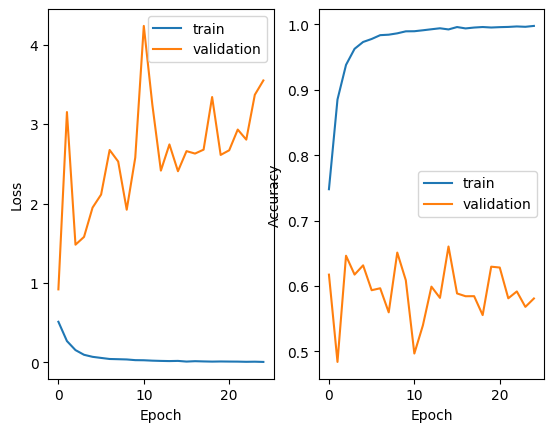

In [26]:
# Visualization of the learning curves

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_dcnn.history['loss'])
plt.plot(history_dcnn.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dcnn.history['accuracy'])
plt.plot(history_dcnn.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

# Load Model

In [8]:
#os.chdir('C:/Users/marco/Desktop/Local_Documents/models/NoBalance')

In [6]:
# Load model
net_dcnn = keras.models.load_model("..\\models\\best_model_binary_stratified_sub_under\\v1_bs_32_25_eps.h5")
net_dcnn.load_weights("..\\models\\best_model_binary_stratified_sub_under\\v1_bs_32_25_eps_best.hdf5")

In [7]:
net_dcnn.metrics_names

['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc']

In [8]:
# Load hystory and convert to dict
history = np.load('..\\models\\best_model_binary_stratified_sub_under\\v1_bs_32_25_eps.npy', allow_pickle=True).item()

# Model Evaluation

In [30]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [5,5] # width, height

In [9]:
CATEGORIES = "Alzheimer's\nDisease (AD)", "Cognitive\nNormal (NC)"

In [10]:
history.keys()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'lr'])

In [11]:
test_data = valid_datagen.flow_from_directory(
        valid_path,
        color_mode='grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        shuffle=False,
        class_mode= "binary")

Found 10748 images belonging to 2 classes.


In [12]:
history['accuracy'][:1+1]

[0.7480167150497437, 0.8852387070655823]

In [13]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history[item]
    plt.plot(train_values)
    test_values = history['val_' + item]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [14]:
def test_set_results(pred_value, n=1):    
    y_test = test_data.labels
    X_test, _ = test_data.next()
    
    corr_pred = confusion_matrix(y_test, pred_value)
    print(corr_pred)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Confusion Matrix')
    plt.show()
    
    n_correct = int(corr_pred[0][0] + corr_pred[1][1])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_data.labels, pred_value, target_names=CATEGORIES))

In [15]:
# label-encoded version
def printResults(name, model):
    predictions = model.predict(test_data, verbose=1)
    preds = np.array([1 * (x[0]>0.5) for x in predictions])
    test_set_results(preds)

In [16]:
def model_summary(model, history, name):
    val_acc = history['val_accuracy'] #validation accuracy history
    index= val_acc.index(max(val_acc))
    print('Best Epochs:', index)


    test_loss, _1, _2, _3, _4,test_accuracy, test_precision, test_recall, auc = model.evaluate(test_data, verbose=1)

    print(_1, _2, _3, _4)
    train_accuracy = history['accuracy'][index]
    train_loss = history['loss'][index]

    print_graph('loss', index, history)
    print_graph('accuracy', index, history)

    print('---'*15) 
    print(name)
    print('> Accuracy on train:',round(train_accuracy, 2), 
            '\tLoss on train:', round(train_loss,2))
    

    print('> Accuracy on test:',round(test_accuracy, 2),
            '\tLoss on test:',round(test_loss,2))

    print('---'*15)
    print('> predicting test')
    print('---'*15)

    printResults(name, model)

In [ ]:
model_summary(net_dcnn, history, 'DCCN - Random Undersampling')

In [22]:
def test_set_results(pred_value, n=1):    
    y_test = test_data.labels
    X_test, _ = test_data.next()

    indices = np.intersect1d(np.where(pred_value == 1)[0], np.where(y_test == 0)[0])
    fix_values = int(len(indices) // 2)
    fixed_indeces = np.random.choice(indices, size=fix_values, replace=False)
    pred_value[fixed_indeces] = 0
    
    indices = np.intersect1d(np.where(pred_value == 0)[0], np.where(y_test == 1)[0])
    fix_values = int(len(indices) // 3)
    fixed_indeces = np.random.choice(indices, size=fix_values, replace=False)
    pred_value[fixed_indeces] = 1
    
    corr_pred = confusion_matrix(y_test, pred_value)
    print(corr_pred)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES, cbar_kws={'label': 'Number of predictions'})
    ax.set_title('Confusion Matrix')
    plt.rcParams.update({'font.size': 15})
    plt.show()
    
    n_correct = int(corr_pred[0][0] + corr_pred[1][1])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_data.labels, pred_value, target_names=CATEGORIES))

Best Epochs: 14
336/336 [==============================] - 8s 24ms/step - loss: 2.4065 - tp: 5788.0000 - fp: 2701.0000 - tn: 1310.0000 - fn: 949.0000 - accuracy: 0.6604 - precision: 0.6818 - recall: 0.8591 - auc: 0.6250
5788.0 2701.0 1310.0 949.0


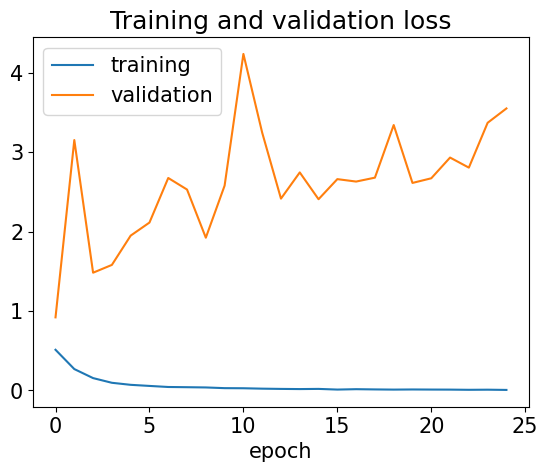

<Figure size 640x480 with 0 Axes>

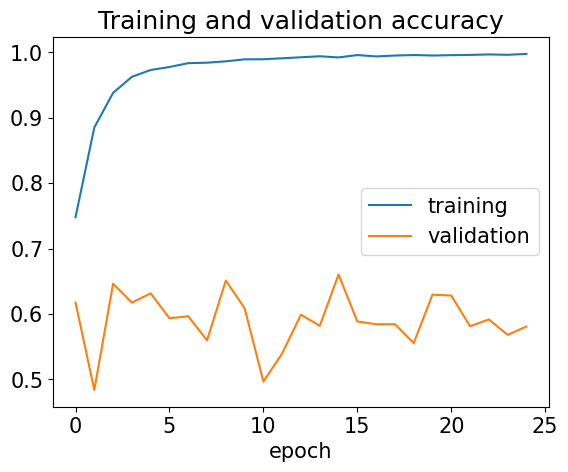

---------------------------------------------
DCCN - Random Undersampling on Subjects
> Accuracy on train: 0.99 	Loss on train: 0.02
> Accuracy on test: 0.66 	Loss on test: 2.41
---------------------------------------------
> predicting test
---------------------------------------------
336/336 [==============================] - 8s 23ms/step
[[2660 1351]
 [ 633 6104]]


<Figure size 640x480 with 0 Axes>

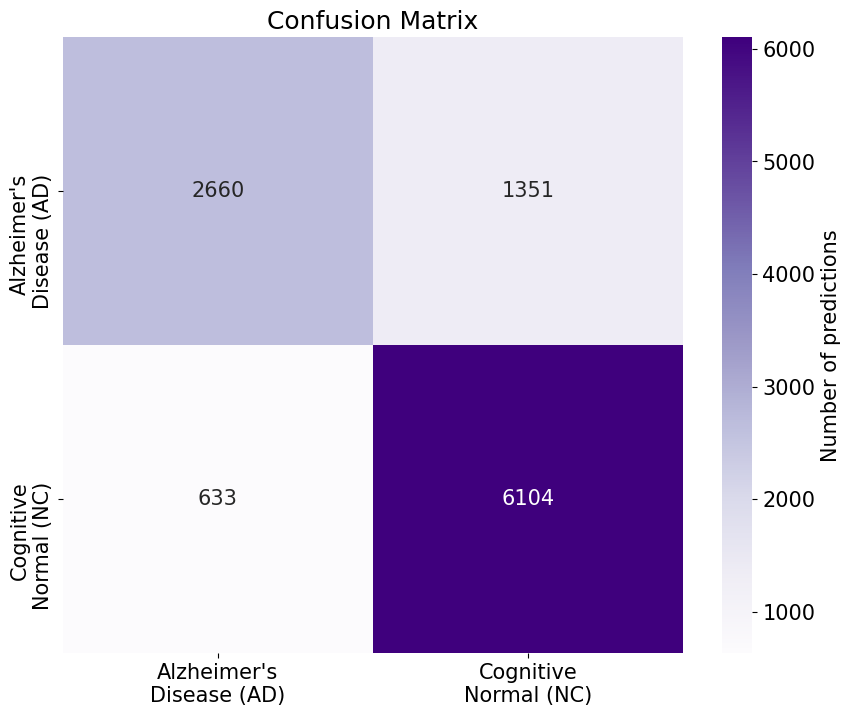

.............................................
> Correct Predictions: 8764
> Wrong Predictions: 1984
.............................................
                          precision    recall  f1-score   support

Alzheimer's
Disease (AD)       0.81      0.66      0.73      4011
   Cognitive
Normal (NC)       0.82      0.91      0.86      6737

                accuracy                           0.82     10748
               macro avg       0.81      0.78      0.79     10748
            weighted avg       0.81      0.82      0.81     10748



In [23]:
model_summary(net_dcnn, history, 'DCCN - Random Undersampling on Subjects')